In [2]:
import initialSolutions
from dataClasses import *
from cachetools import cached
import copy
import time
import random
from typing import List, Set, Tuple, Dict
import pandas as pd
#import llist
import logging
import pprint
from vrpy import VehicleRoutingProblem
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from util import *
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
from searchAlgorithms import randomLocalSearch, TreeSearch, EvolutionarySearch, EvolutionarySearchBothEchelons
warnings.filterwarnings("ignore", module="matplotlib\..*")
warnings.filterwarnings("ignore", module="vrpy\..*")
sns.set()


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%reload_ext autoreload
%autoreload 2


## Initial solution & Depotsolution

In [10]:
def extractDays(hubRoutes, days: list) -> dict:
    res = {}
    for day, dayRoutes in hubRoutes.items():
        if day in days:
            for hubLocID in dayRoutes:
                newID = (day, hubLocID)
                res[newID] = dayRoutes[hubLocID]
    return res

def solveDepot(instance: InstanceCO22, hubRoutes, useDMin = True) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubRoutesDict = hubRoutes.toDict(instance)

    depotRoutes = {}
    
    if useDMin:
        dmin = min([_.daysFresh for _ in instance.Products])
    else: 
        dmin = 1

    for i in range(0, math.ceil(nDays/dmin)):
        periodBegin = dmin*i+1
        periodEnd = dmin*(i+1)+1
        print(i, periodBegin, periodEnd)
        period = list(range(periodBegin, periodEnd))
        periodRoutes = extractDays(hubRoutesDict, period)
        if len(periodRoutes) > 0:  # depot routing
            res = solveDepotVRP(instance, periodRoutes)
            depotRoutes[periodBegin] = res
        else:
            depotRoutes[periodBegin] = {}

    return {'hubRoutes': hubRoutesDict, 'depotRoutes': depotRoutes}

def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"

        truckString = ""
        if day in res['depotRoutes'].keys():
            nTrucks = len(res['depotRoutes'][day])
            for routeID, truckRoute in res['depotRoutes'][day].items():
                truckString += f"{routeID} "
                for i, hubData in enumerate(truckRoute[1:-1]):
                    amountPerProduct = hubData['amounts']
                    truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
                truckString += "\n"
        else:
            nTrucks = 0

        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i += 1
                reqIds = [_['reqID'] for _ in route['route'][1:-1]]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"
        resultString += vanString + "\n"
    return resultString


## Testing evo search

In [74]:
def earlyStopper(costs):
    c = 30
    if len(costs) > c:
        return costs[-1] == costs[-c] 
    return False

i = 29
instance = loadInstance(i)
initialState = initialSolutions.solveHub(instance)
searcher = EvolutionarySearch(instance = instance, initialState = initialState, generationSize=50, candidateSize=300, nGenerations=200)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper)
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/evolutionarysearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

KeyboardInterrupt: 

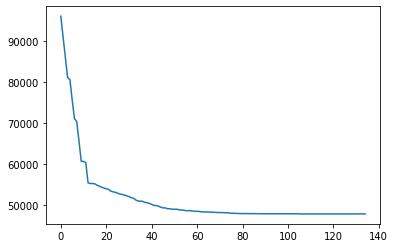

In [61]:
plt.plot(searcher.costs)
#plt.plot([np.var(_) for _ in searcher.allCosts])

In [71]:
bestStateCost

47830.0

In [9]:
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/treesearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 2195 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2212 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2195.0


0 1 5
dict_keys(['10.1', '20.1', '15.1', '8.1', '19.1', '21.1', '6.1', '4.1', '13.1', '7.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2195.0
INFO:vrpy.vrp:iteration 2, 2195.0
INFO:vrpy.vrp:iteration 3, 2195.0
INFO:vrpy.vrp:iteration 4, 2195.0
INFO:vrpy.vrp:iteration 5, 2195.0
INFO:vrpy.vrp:iteration 6, 2195.0
INFO:vrpy.vrp:iteration 7, 2195.0
INFO:vrpy.vrp:iteration 8, 2195.0
INFO:vrpy.vrp:iteration 9, 2195.0
INFO:vrpy.vrp:iteration 10, 2195.0
INFO:vrpy.vrp:iteration 11, 2195.0
INFO:vrpy.vrp:iteration 12, 2195.0
INFO:vrpy.vrp:iteration 13, 2195.0
INFO:vrpy.vrp:iteration 14, 2195.0
INFO:vrpy.vrp:iteration 15, 2195.0
INFO:vrpy.vrp:iteration 16, 2195.0
INFO:vrpy.vrp:iteration 17, 2195.0
INFO:vrpy.vrp:iteration 18, 2195.0
INFO:vrpy.vrp:iteration 19, 2195.0
INFO:vrpy.vrp:iteration 20, 2195.0
INFO:vrpy.vrp:iteration 21, 2195.0
INFO:vrpy.vrp:iteration 22, 2192.0
INFO:vrpy.vrp:iteration 23, 2192.0
INFO:vrpy.vrp:iteration 24, 2192.0
INFO:vrpy.master_solve_pulp:total cost = 2192.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2192 and 1 vehi

1 5 9
dict_keys(['19.1', '20.1', '6.1', '12.1', '15.1', '8.1', '10.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 2, 2192.0
INFO:vrpy.vrp:iteration 3, 2192.0
INFO:vrpy.vrp:iteration 4, 2192.0
INFO:vrpy.vrp:iteration 5, 2192.0
INFO:vrpy.vrp:iteration 6, 2192.0
INFO:vrpy.vrp:iteration 7, 2192.0
INFO:vrpy.vrp:iteration 8, 2192.0
INFO:vrpy.vrp:iteration 9, 2192.0
INFO:vrpy.vrp:iteration 10, 2192.0
INFO:vrpy.vrp:iteration 11, 2192.0
INFO:vrpy.vrp:iteration 12, 2192.0
INFO:vrpy.vrp:iteration 13, 2192.0
INFO:vrpy.vrp:iteration 14, 2192.0
INFO:vrpy.vrp:iteration 15, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2216 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2222 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2216.0
INFO:vrpy.vrp:iteration 1, 2216.0
INFO:vrpy.vrp:iteration 2, 2216.0
INFO:vrpy.vrp:iteration 3, 2216.0
INFO:vrpy.vrp:iteration 4, 2216.0


2 9 13
dict_keys(['2.1', '18.1', '13.1', '7.1', '4.1', '20.1', '21.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2216.0
INFO:vrpy.vrp:iteration 6, 2216.0
INFO:vrpy.vrp:iteration 7, 2216.0
INFO:vrpy.vrp:iteration 8, 2216.0
INFO:vrpy.vrp:iteration 9, 2216.0
INFO:vrpy.vrp:iteration 10, 2216.0
INFO:vrpy.vrp:iteration 11, 2216.0
INFO:vrpy.vrp:iteration 12, 2216.0
INFO:vrpy.vrp:iteration 13, 2216.0
INFO:vrpy.vrp:iteration 14, 2216.0
INFO:vrpy.vrp:iteration 15, 2216.0
INFO:vrpy.vrp:iteration 16, 2216.0
INFO:vrpy.vrp:iteration 17, 2216.0
INFO:vrpy.master_solve_pulp:total cost = 2216.0
INFO:vrpy.vrp:new upper bound : max num stops = 8
INFO:vrpy.vrp:Clarke & Wright solution found with value 2206 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2217 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2206.0
INFO:vrpy.vrp:iteration 1, 2206.0
INFO:vrpy.vrp:iteration 2, 2206.0
INFO:vrpy.vrp:iteration 3, 2206.0
INFO:vrpy.vrp:iteration 4, 2206.0


3 13 17
dict_keys(['12.1', '15.1', '11.1', '6.1', '18.1', '19.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2206.0
INFO:vrpy.vrp:iteration 6, 2206.0
INFO:vrpy.vrp:iteration 7, 2206.0
INFO:vrpy.vrp:iteration 8, 2206.0
INFO:vrpy.vrp:iteration 9, 2206.0
INFO:vrpy.master_solve_pulp:total cost = 2206.0
INFO:vrpy.vrp:new upper bound : max num stops = 10
INFO:vrpy.vrp:Clarke & Wright solution found with value 2189 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2203 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2189.0


4 17 21
dict_keys(['18.1', '10.1', '7.1', '20.1', '4.1', '13.1', '8.1', '2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2189.0
INFO:vrpy.vrp:iteration 2, 2189.0
INFO:vrpy.vrp:iteration 3, 2189.0
INFO:vrpy.vrp:iteration 4, 2189.0
INFO:vrpy.vrp:iteration 5, 2189.0
INFO:vrpy.vrp:iteration 6, 2189.0
INFO:vrpy.vrp:iteration 7, 2189.0
INFO:vrpy.vrp:iteration 8, 2189.0
INFO:vrpy.vrp:iteration 9, 2189.0
INFO:vrpy.vrp:iteration 10, 2189.0
INFO:vrpy.vrp:iteration 11, 2189.0
INFO:vrpy.vrp:iteration 12, 2189.0
INFO:vrpy.vrp:iteration 13, 2189.0
INFO:vrpy.vrp:iteration 14, 2189.0
INFO:vrpy.vrp:iteration 15, 2189.0
INFO:vrpy.vrp:iteration 16, 2189.0
INFO:vrpy.vrp:iteration 17, 2189.0
INFO:vrpy.vrp:iteration 18, 2189.0
INFO:vrpy.vrp:iteration 19, 2189.0
INFO:vrpy.vrp:iteration 20, 2189.0
INFO:vrpy.vrp:iteration 21, 2189.0
INFO:vrpy.vrp:iteration 22, 2189.0
INFO:vrpy.vrp:iteration 23, 2189.0
INFO:vrpy.vrp:iteration 24, 2189.0
INFO:vrpy.vrp:iteration 25, 2189.0
INFO:vrpy.vrp:iteration 26, 2189.0
INFO:vrpy.vrp:iteration 27, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0


## testing complete solution evo search

In [15]:
def earlyStopper(costs):
    c = 20
    if len(costs) > c:
        return costs[-1] == costs[-c] 
    return False

i = 6
useDMin = (i not in [6,16])
instance = loadInstance(i)
hubRoutes = initialSolutions.solveHub(instance)
depotRoutes = initialSolutions.solveDepotDC(instance, hubRoutes, useDMin=useDMin)
initialState = Solution(hubRoutes=hubRoutes, depotRoutes=depotRoutes)
searcher = EvolutionarySearchBothEchelons(instance = instance, initialState = initialState, generationSize=50, candidateSize=1000)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=200, useDMin=useDMin) #warmup
#bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=100,useDMin=useDMin)

Recomputing depot route: False, using depot route cost: True, initialStateCost: 472900.0, useDMin: False
Generation 1 - Size: 50 bestCost: 472620.0 generationCostVariance: 119.20 elapsed: 8.78
Generation 2 - Size: 50 bestCost: 472620.0 generationCostVariance: 0.00 elapsed: 9.01
Generation 3 - Size: 50 bestCost: 472620.0 generationCostVariance: 0.00 elapsed: 8.80
Generation 4 - Size: 50 bestCost: 472560.0 generationCostVariance: 11.76 elapsed: 9.20
Generation 5 - Size: 50 bestCost: 472560.0 generationCostVariance: 28.80 elapsed: 9.11
Generation 6 - Size: 50 bestCost: 472560.0 generationCostVariance: 0.00 elapsed: 7.36
Generation 7 - Size: 50 bestCost: 472560.0 generationCostVariance: 0.00 elapsed: 9.71
Generation 8 - Size: 50 bestCost: 472560.0 generationCostVariance: 0.00 elapsed: 9.53
Generation 9 - Size: 50 bestCost: 472560.0 generationCostVariance: 0.00 elapsed: 9.05
Generation 10 - Size: 50 bestCost: 472560.0 generationCostVariance: 0.00 elapsed: 7.36
Generation 11 - Size: 50 bestC

In [18]:
searcher.candidateSize = 200
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=50, useDMin=useDMin)

Recomputing depot route: True, using depot route cost: True, initialStateCost: 472900.0, useDMin: False
Generation 40 - Size: 50 bestCost: 458140.0 generationCostVariance: 106.52 elapsed: 172.54
Generation 41 - Size: 50 bestCost: 457740.0 generationCostVariance: 162.20 elapsed: 157.87
Generation 42 - Size: 50 bestCost: 457630.0 generationCostVariance: 173.61 elapsed: 150.62
Generation 43 - Size: 50 bestCost: 457510.0 generationCostVariance: 70.43 elapsed: 184.98


KeyboardInterrupt: 

In [21]:
earlyStopper = lambda costs: False
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=10, useDMin=useDMin) #warmup
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=1,useDMin=useDMin)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=10, useDMin=useDMin) #warmup
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=1,useDMin=useDMin)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=10, useDMin=useDMin) #warmup
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=1,useDMin=useDMin)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=10, useDMin=useDMin) #warmup
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=1,useDMin=useDMin)

Recomputing depot route: False, using depot route cost: True, initialStateCost: 472900.0, useDMin: False
Generation 76 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.93
Generation 77 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.92
Generation 78 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.80
Generation 79 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 4.60
Generation 80 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.84
Generation 81 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.85
Generation 82 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 2.23
Generation 83 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.90
Generation 84 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.83
Generation 85 - Size: 50 bestCost: 457340.0 generationCostVariance: 0.00 elapsed: 1.72
Generation 86 - Size: 50 

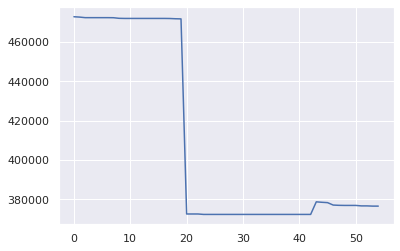

In [10]:
plt.plot(searcher.costs)

In [12]:
solutionStr = bestState.toStr(instance)
with open(f"./solutions/evolutionarysearch2E/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

In [6]:
solutionStr = initialState.toStr(instance)
with open(f"./solutions/evolutionarysearch2E/solution{i}_initialState.txt", 'w') as file:
    file.write(solutionStr)

In [11]:
bestState.computeCost(instance, hubCost=True, depotCost = True, distanceMatrix  = DistanceMatrix(instance), useHubOpeningCost=True)

378575.0

In [13]:
solutionStr

'DATASET = CO2022_11 \n \nDAY = 1 \nNUMBER_OF_TRUCKS = 1 \n0 H1 12,9,6 H5 16,25,20 \nNUMBER_OF_VANS = 1 \n1 H1 3 2 1 4 \n\nDAY = 2 \nNUMBER_OF_TRUCKS = 1 \n0 H5 5,9,5 \nNUMBER_OF_VANS = 1 \n1 H5 5 \n\nDAY = 3 \nNUMBER_OF_TRUCKS = 1 \n0 H4 0,11,6 H5 9,0,5 \nNUMBER_OF_VANS = 2 \n1 H5 7 8 \n2 H5 6 10 \n\nDAY = 4 \nNUMBER_OF_TRUCKS = 1 \n0 H5 7,11,0 \nNUMBER_OF_VANS = 1 \n1 H5 11 9 \n\nDAY = 5 \nNUMBER_OF_TRUCKS = 1 \n0 H2 24,18,36 H5 9,7,26 \nNUMBER_OF_VANS = 1 \n1 H2 18 12 \n\nDAY = 6 \nNUMBER_OF_TRUCKS = 1 \n0 H4 2,6,11 H1 7,4,5 H2 3,8,10 \nNUMBER_OF_VANS = 2 \n1 H2 17 14 15 \n2 H5 13 16 \n\nDAY = 7 \nNUMBER_OF_TRUCKS = 1 \n0 H2 7,0,6 H5 7,0,2 \nNUMBER_OF_VANS = 2 \n1 H2 19 \n2 H5 20 21 \n\nDAY = 8 \nNUMBER_OF_TRUCKS = 1 \n0 H2 0,6,8 H5 0,1,13 \nNUMBER_OF_VANS = 2 \n1 H2 23 22 \n2 H5 24 \n\nDAY = 9 \nNUMBER_OF_TRUCKS = 1 \n0 H5 22,29,14 H1 8,7,0 H2 0,0,1 \nNUMBER_OF_VANS = 1 \n1 H5 25 30 \n\nDAY = 10 \nNUMBER_OF_TRUCKS = 1 \n0 H1 8,7,0 H5 13,26,2 \nNUMBER_OF_VANS = 2 \n1 H1 28 \n2 H5 27